In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier


# Preprocessing

In [2]:
def preprocess_data_with_target(df, target):
    """
    Preprocess dataset with target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features
      - Separates features (X) and target (y)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.
    target : str
        The name of the target column.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    y : pandas.Series
        Encoded target column
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # Handle Missing Values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # Separate Features and Target
    X = df.drop(columns=[target])
    y = df[target]

    # Encode Categorical Columns
    encoders = {}
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le

    # Encode target if categorical
    if y.dtype == 'object' or str(y.dtype) == 'category':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        encoders[target] = le_target

    # Standardize Numerical Features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of X after transformation: \n{X.head()}\n*********************")
    print(f"First 5 Rows of y after transformation: \n{y[:5]}\n********************* \n")

    return X, y, encoders, scaler


In [3]:
def preprocess_data_no_target(df):
    """
    Preprocess dataset without a target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # Handle Missing Values 
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # Encode Categorical Columns 
    encoders = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    # Standardize Numerical Features 
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of Data after transformation: \n{df.head()}\n*********************")

    return df, encoders, scaler


In [4]:
# Load project_adult.csv as pa
pa = pd.read_csv("project_adult.csv")

# Apply preprocess function on pa
pa_X, pa_y, pa_encoders, pa_scaler = preprocess_data_with_target(df = pa, target = "income")

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-countr

In [5]:
# Load project_validation_inputs.csv as pv
pv = pd.read_csv("project_validation_inputs.csv")

# Apply preprocess function on pa
pv_X, pv_encoders, pv_scaler = preprocess_data_no_target(df = pv)

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0       14160   27           Private  160178  Some-college             10   
1       27048   45         State-gov   50567       HS-grad              9   
2       28868   29           Private  185908     Bachelors             13   
3        5667   30           Private  190040     Bachelors             13   
4        7827   29  Self-emp-not-inc  189346  Some-college             10   

       marital-status         occupation   relationship   race     sex  \
0            Divorced       Adm-clerical  Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial           Wife  White  Female   
2  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
3       Never-married  Machine-op-inspct  Not-in-family  White  Female   
4            Divorced       Craft-repair  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week n

# Perceptron

In [6]:
# Perceptron class
class Perceptron:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)


In [7]:
# Test/Train split
pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(
    pa_X.values, pa_y, test_size=0.3, random_state=42, stratify=pa_y
)

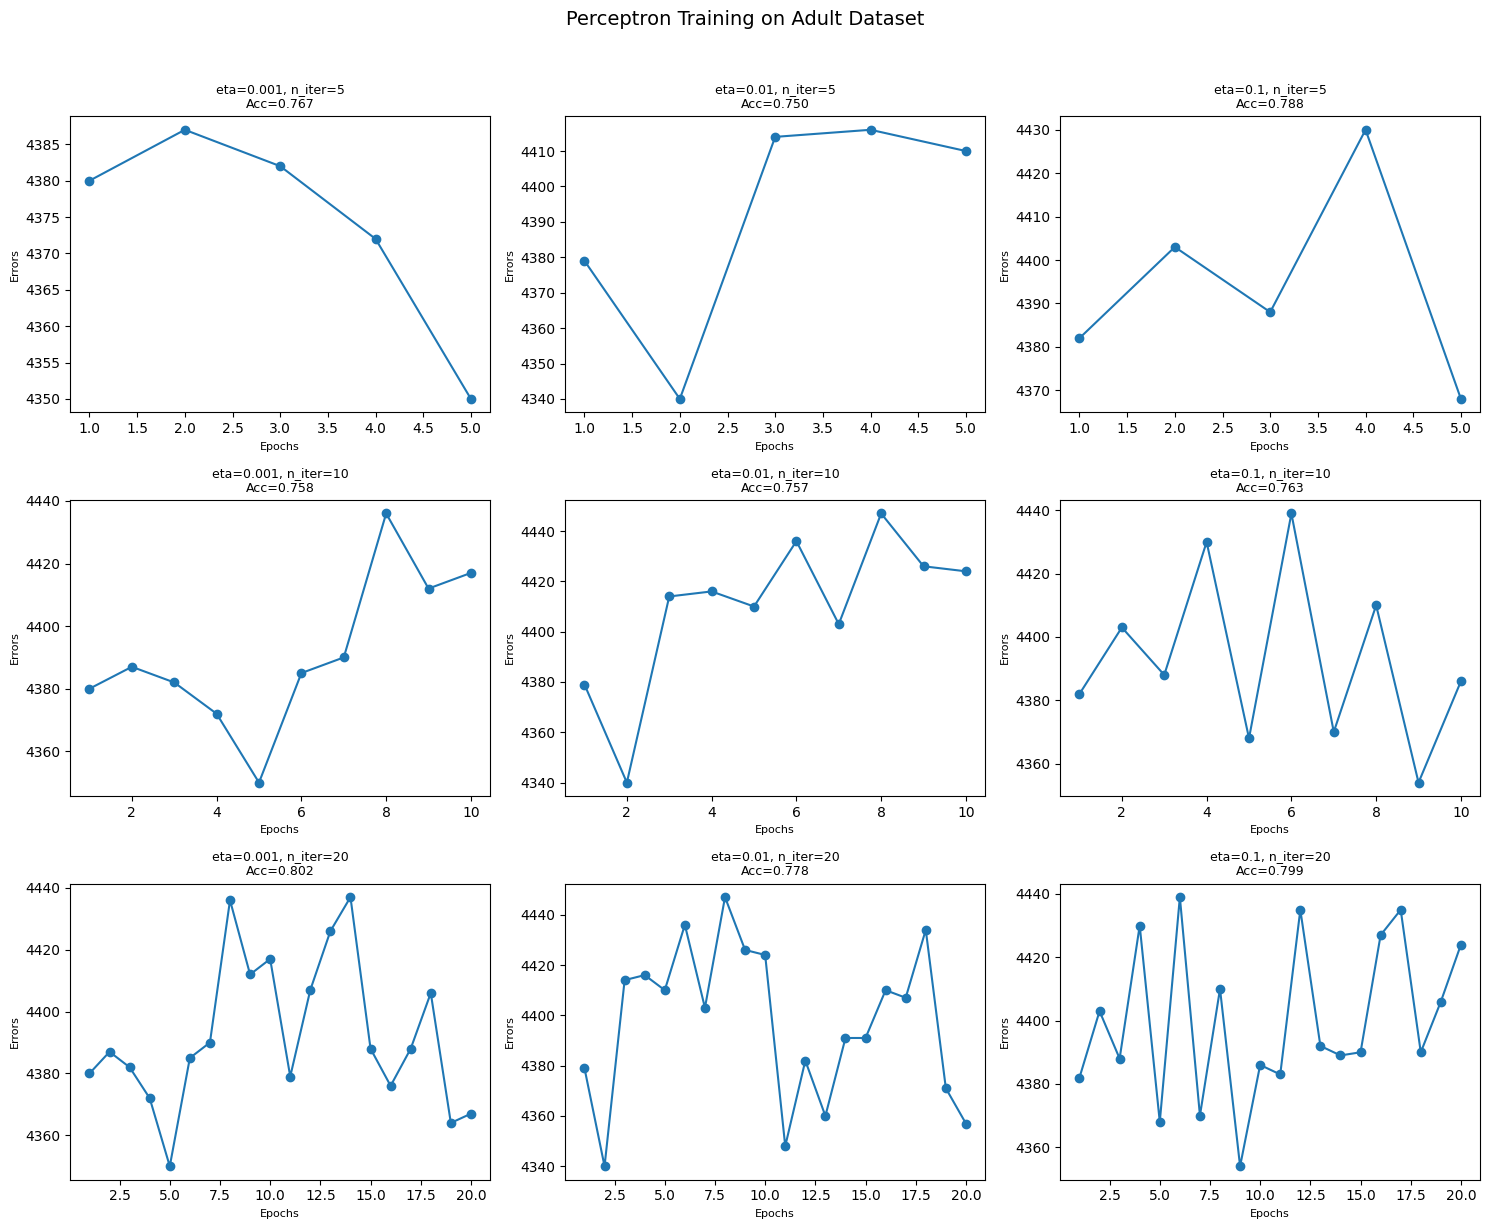

In [8]:
# Grid search with epoch plots
list_eta = [0.001, 0.01, 0.1]
list_niter = [5, 10, 20]

fig, ax = plt.subplots(nrows=len(list_niter), ncols=len(list_eta), figsize=(15, 12))
fig.suptitle("Perceptron Training on Adult Dataset", fontsize=14, y=1.02)

best_acc = 0.0
best_params = None
best_model = None

for j, n_temp in enumerate(list_niter):
    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta=e_temp, random_state=1).fit(pa_X_train, pa_y_train)
        pa_y_pred = ppn.predict(pa_X_test)
        acc = accuracy_score(pa_y_test, pa_y_pred)

        # Plot misclassification errors per epoch
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=8)
        ax[j, i].set_ylabel('Errors', fontsize=8)
        ax[j, i].set_title(f"eta={e_temp}, n_iter={n_temp}\nAcc={acc:.3f}", fontsize=9)

        # Track best model
        if acc > best_acc:
            best_acc = acc
            best_params = (e_temp, n_temp)
            best_model = ppn

plt.tight_layout()
plt.show()

Best Perceptron model: eta=0.001, n_iter=20
Test set accuracy: 0.8024


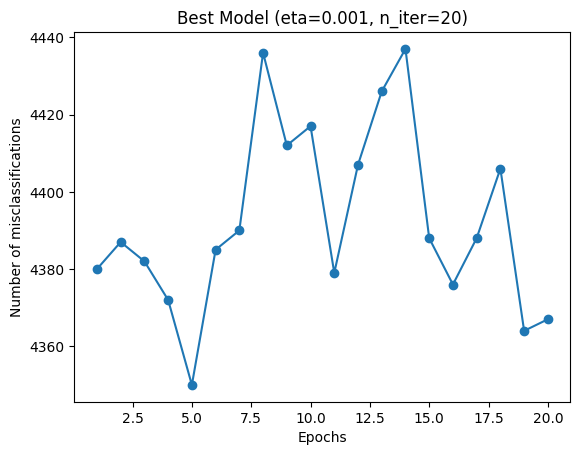

In [9]:
# Report best model
print(f"Best Perceptron model: eta={best_params[0]}, n_iter={best_params[1]}")
print(f"Test set accuracy: {best_acc:.4f}")

# Plot best model’s error curve
plt.plot(range(1, len(best_model.errors_) + 1), best_model.errors_, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Number of misclassifications")
plt.title(f"Best Model (eta={best_params[0]}, n_iter={best_params[1]})")
plt.show()


In [10]:
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(pa_X_train, pa_y_train)
sk_y_pred_ppn = sk_ppn.predict(pa_X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(pa_y_test, sk_y_pred_ppn):.4f}")

Scikit-learn Perceptron accuracy: 0.8114


In [11]:
validation_preds = sk_ppn.predict(pv_X.values)

# Map predictions back to original income labels if target_le available
target_le = pa_encoders.get("income")
if target_le is not None:
    readable_preds = target_le.inverse_transform(validation_preds)
    output_df = pv.copy()
    output_df['Predicted_Income'] = readable_preds
else:
    output_df = pv.copy()
    output_df['Predicted_Income'] = validation_preds

# save just output labels
output_df[['Predicted_Income']].to_csv("Group_23_Perceptron_PredictedOutputs.csv", index=False)
print("Validation predictions saved to Group_23_Perceptron_PredictedOutputs.csv")


Validation predictions saved to Group_23_Perceptron_PredictedOutputs.csv
